Normalization stats:
Mean: tensor([3890.4319, 5889.9810])
Std: tensor([1265.4392, 1915.2719])
History range before norm: -1.00 to 6575.00
History range after norm: -3.08 to 0.37


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([57, 1, 2])) that is different to the input size (torch.Size([57, 80, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch 50/500
epoch loss: 0.0005775440367870033
Average loss: 0.000578


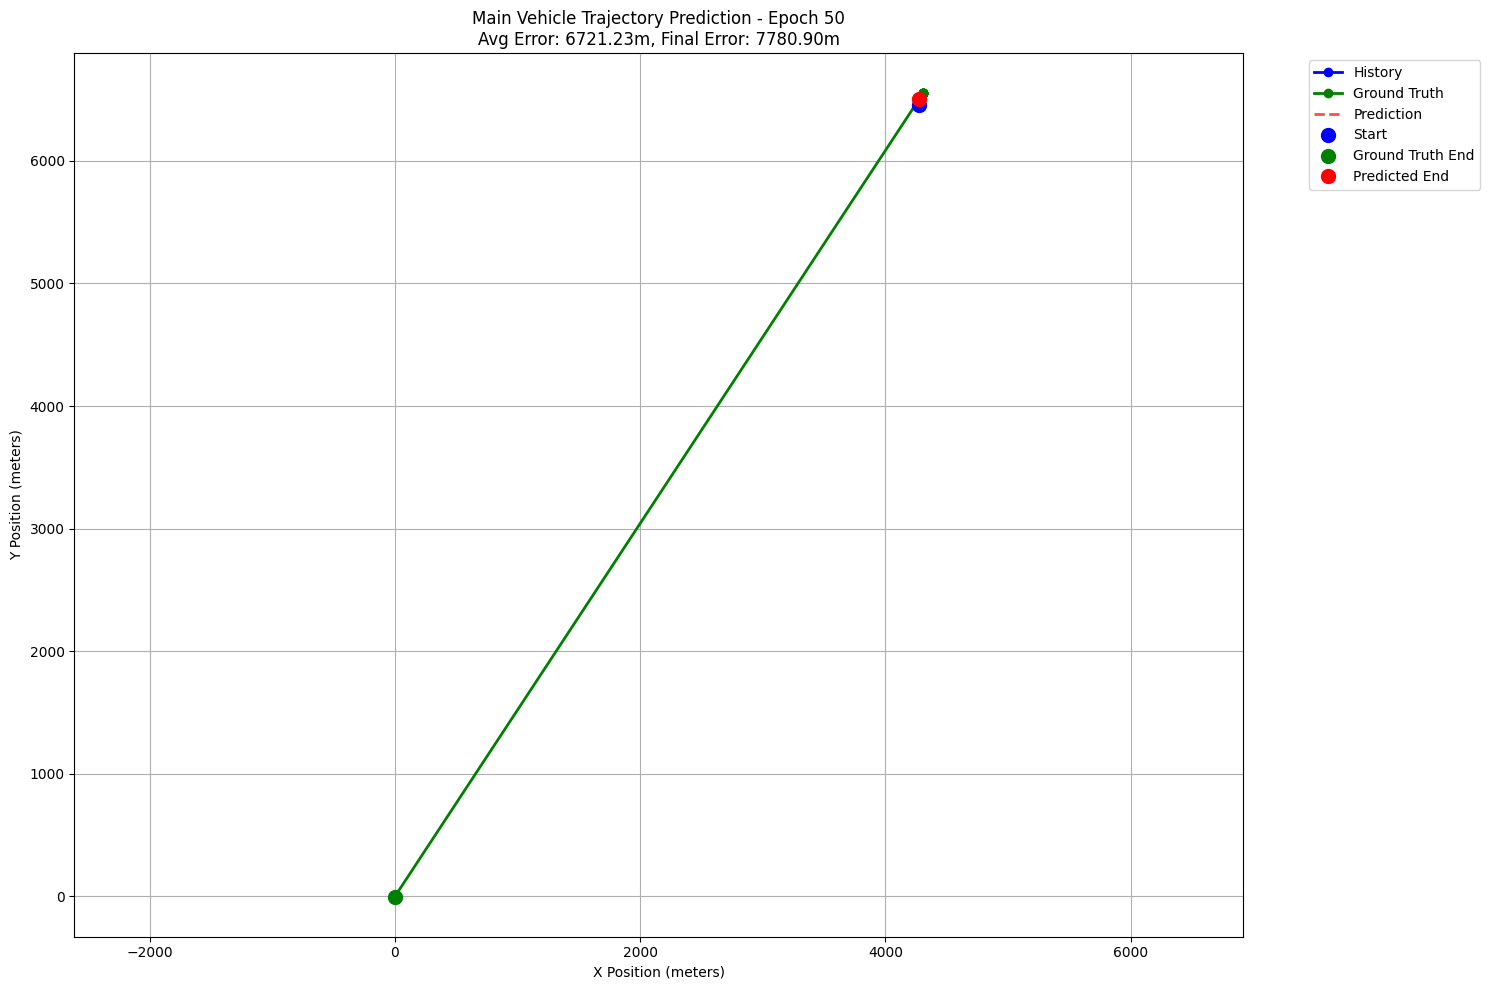


Prediction Statistics:
Average prediction error: 6721.23 meters
Final position error: 7780.90 meters
Trajectory length - History: 11 steps, Future: 80 steps

Epoch 100/500
epoch loss: 0.00020453626348171383
Average loss: 0.000205


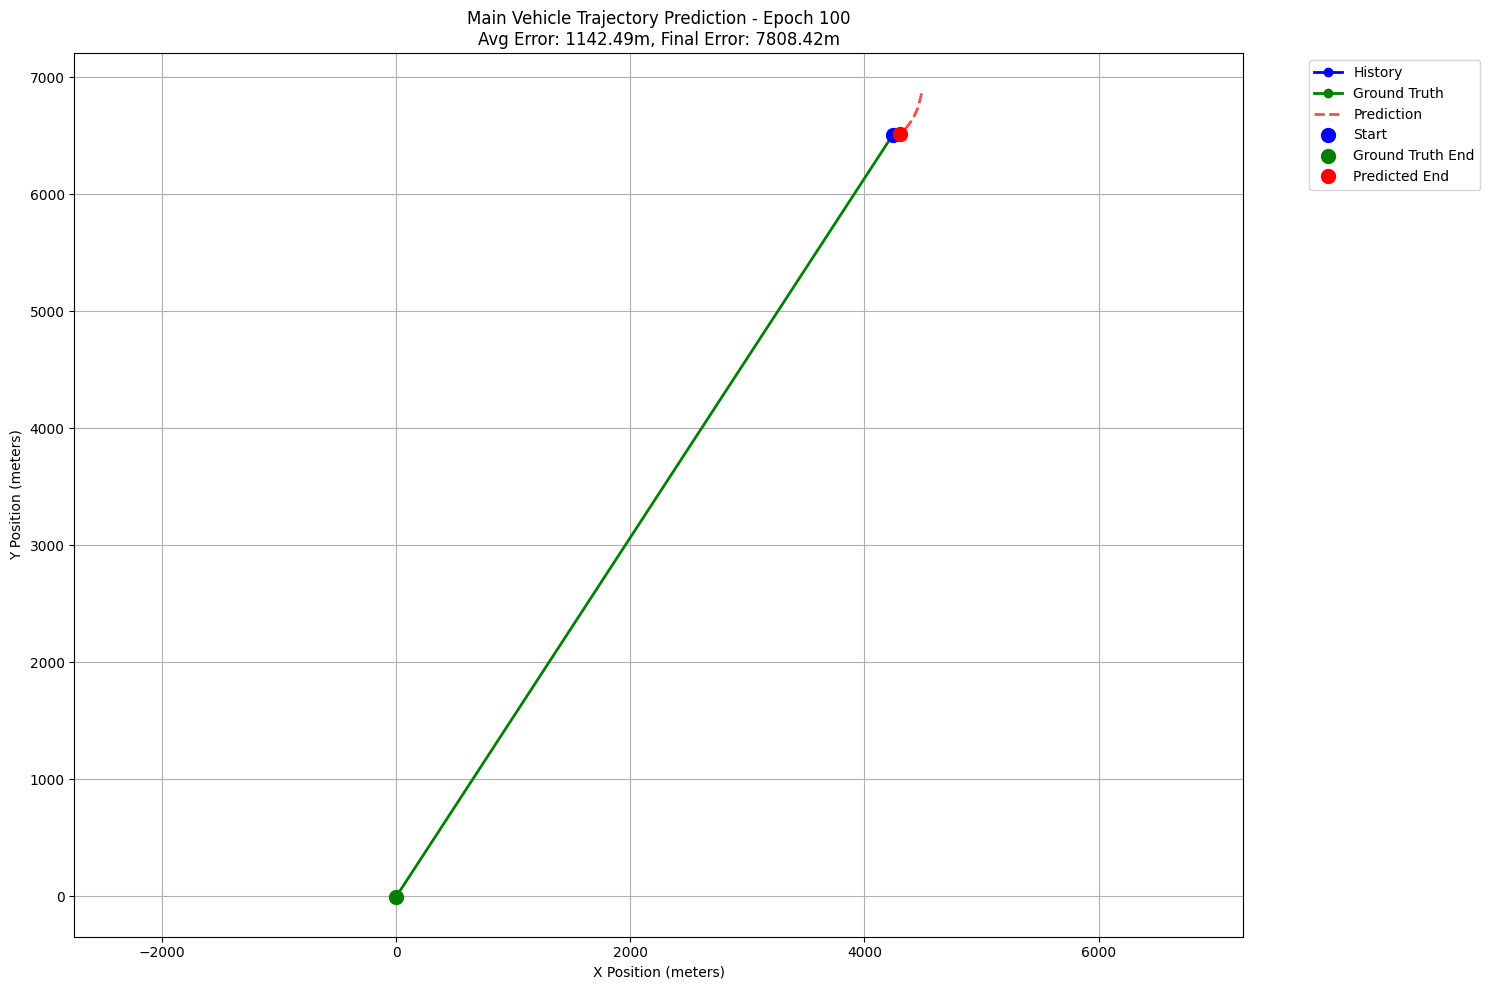


Prediction Statistics:
Average prediction error: 1142.49 meters
Final position error: 7808.42 meters
Trajectory length - History: 11 steps, Future: 80 steps

Epoch 150/500
epoch loss: 0.00017143778677564114
Average loss: 0.000171


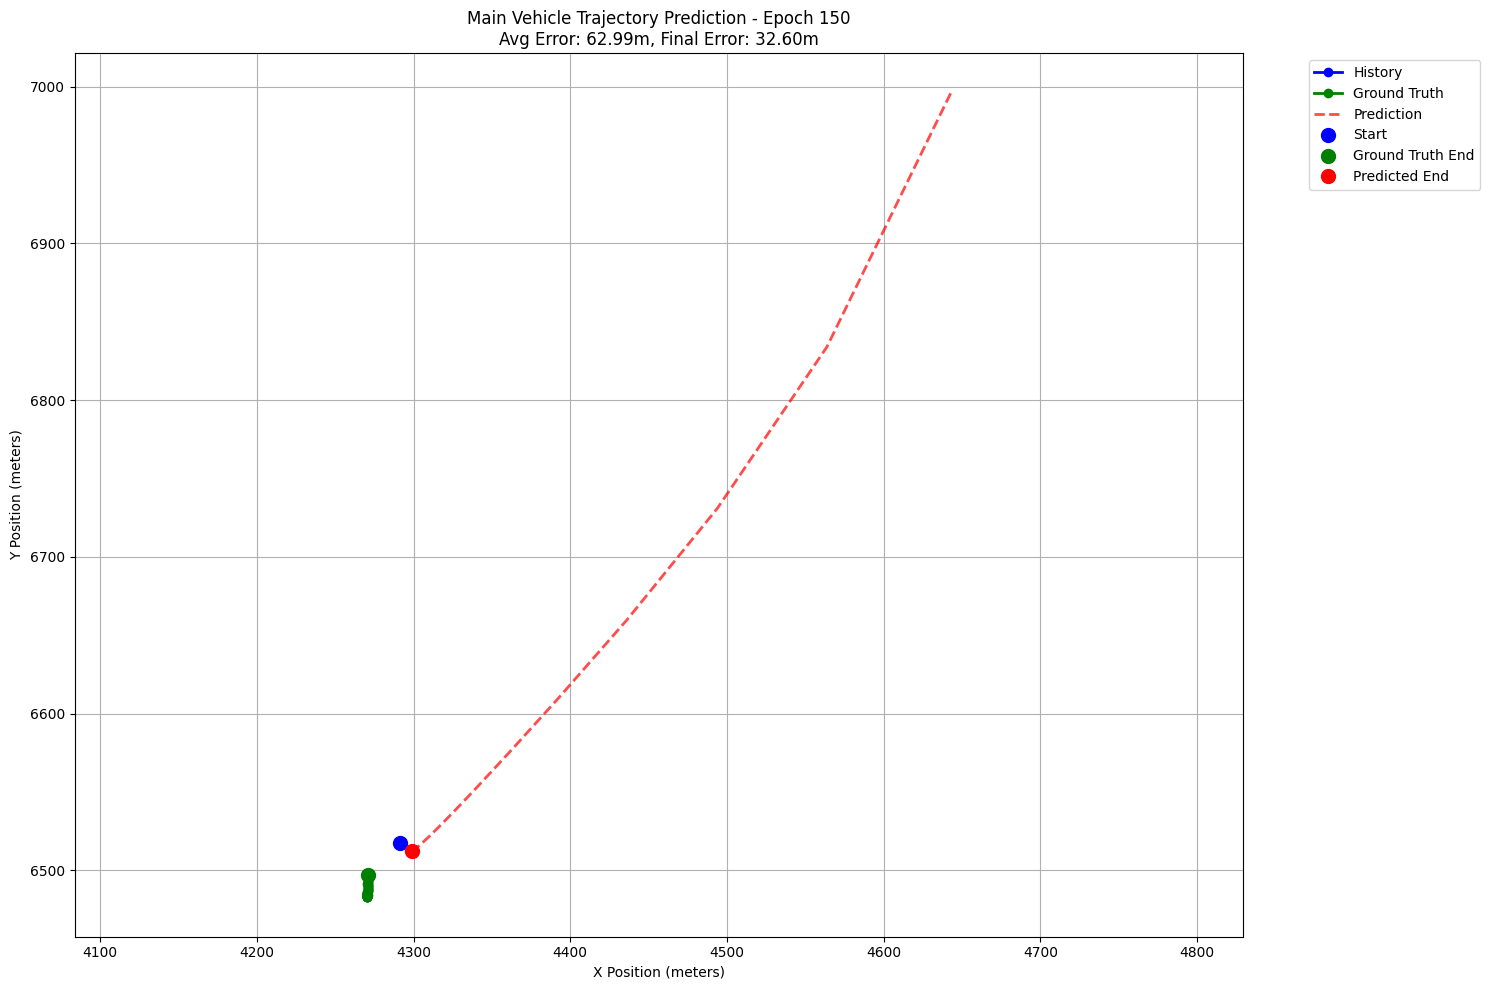


Prediction Statistics:
Average prediction error: 62.99 meters
Final position error: 32.60 meters
Trajectory length - History: 11 steps, Future: 80 steps

Epoch 200/500
epoch loss: 0.00016773445531725883
Average loss: 0.000168


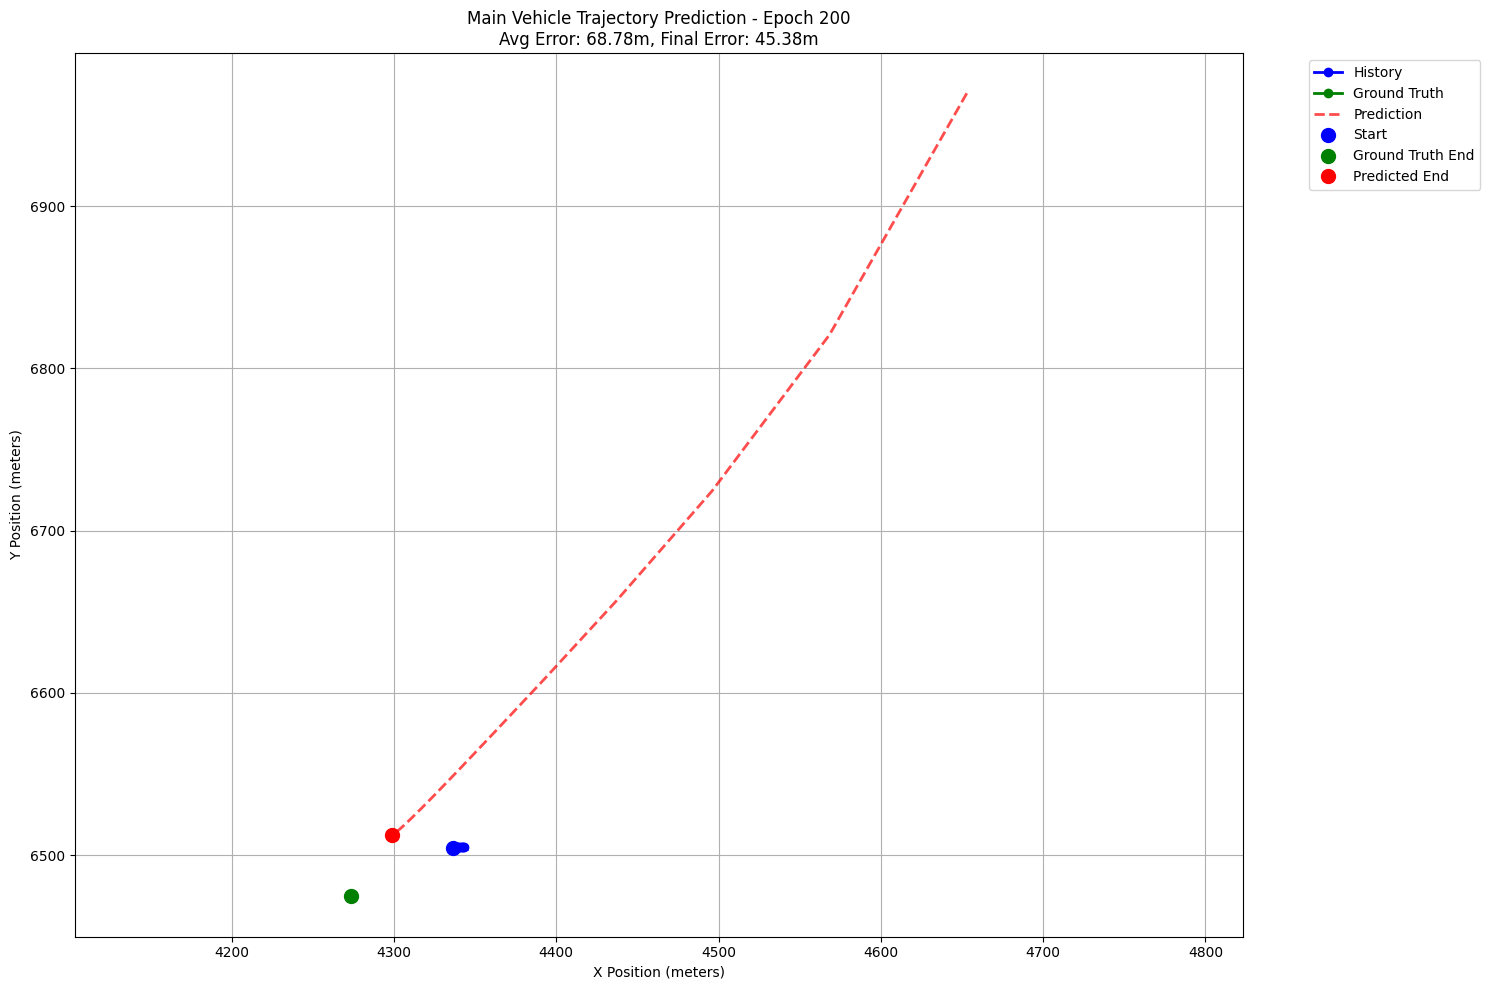


Prediction Statistics:
Average prediction error: 68.78 meters
Final position error: 45.38 meters
Trajectory length - History: 11 steps, Future: 80 steps

Epoch 250/500
epoch loss: 0.00016709107148926705
Average loss: 0.000167


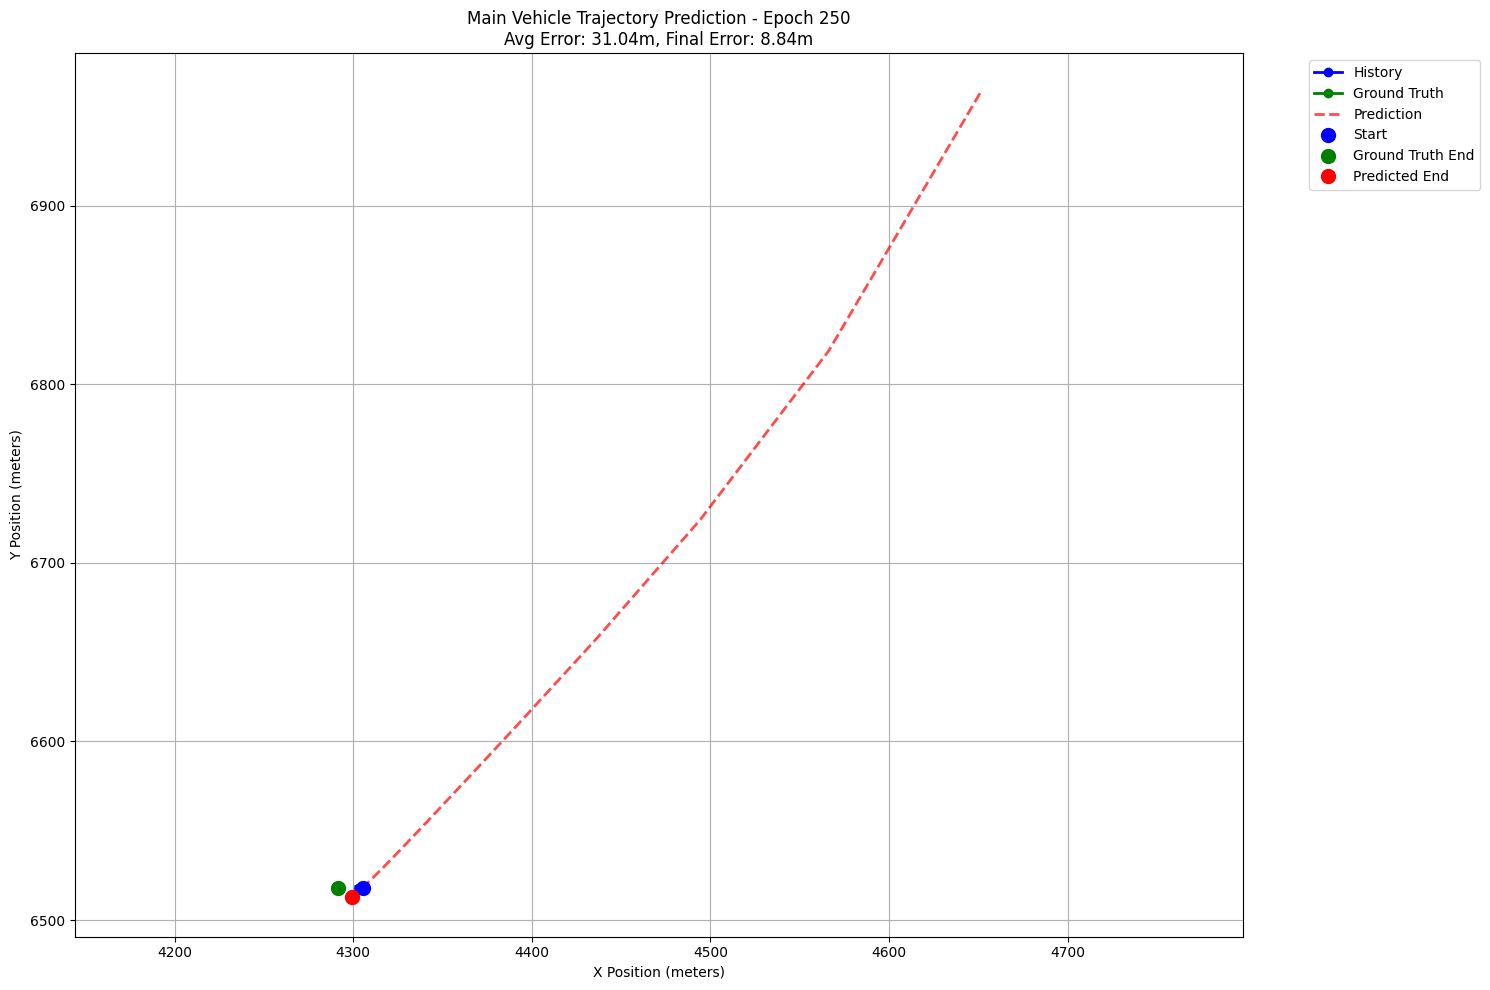


Prediction Statistics:
Average prediction error: 31.04 meters
Final position error: 8.84 meters
Trajectory length - History: 11 steps, Future: 80 steps

Epoch 300/500
epoch loss: 0.00015634173178113997
Average loss: 0.000156


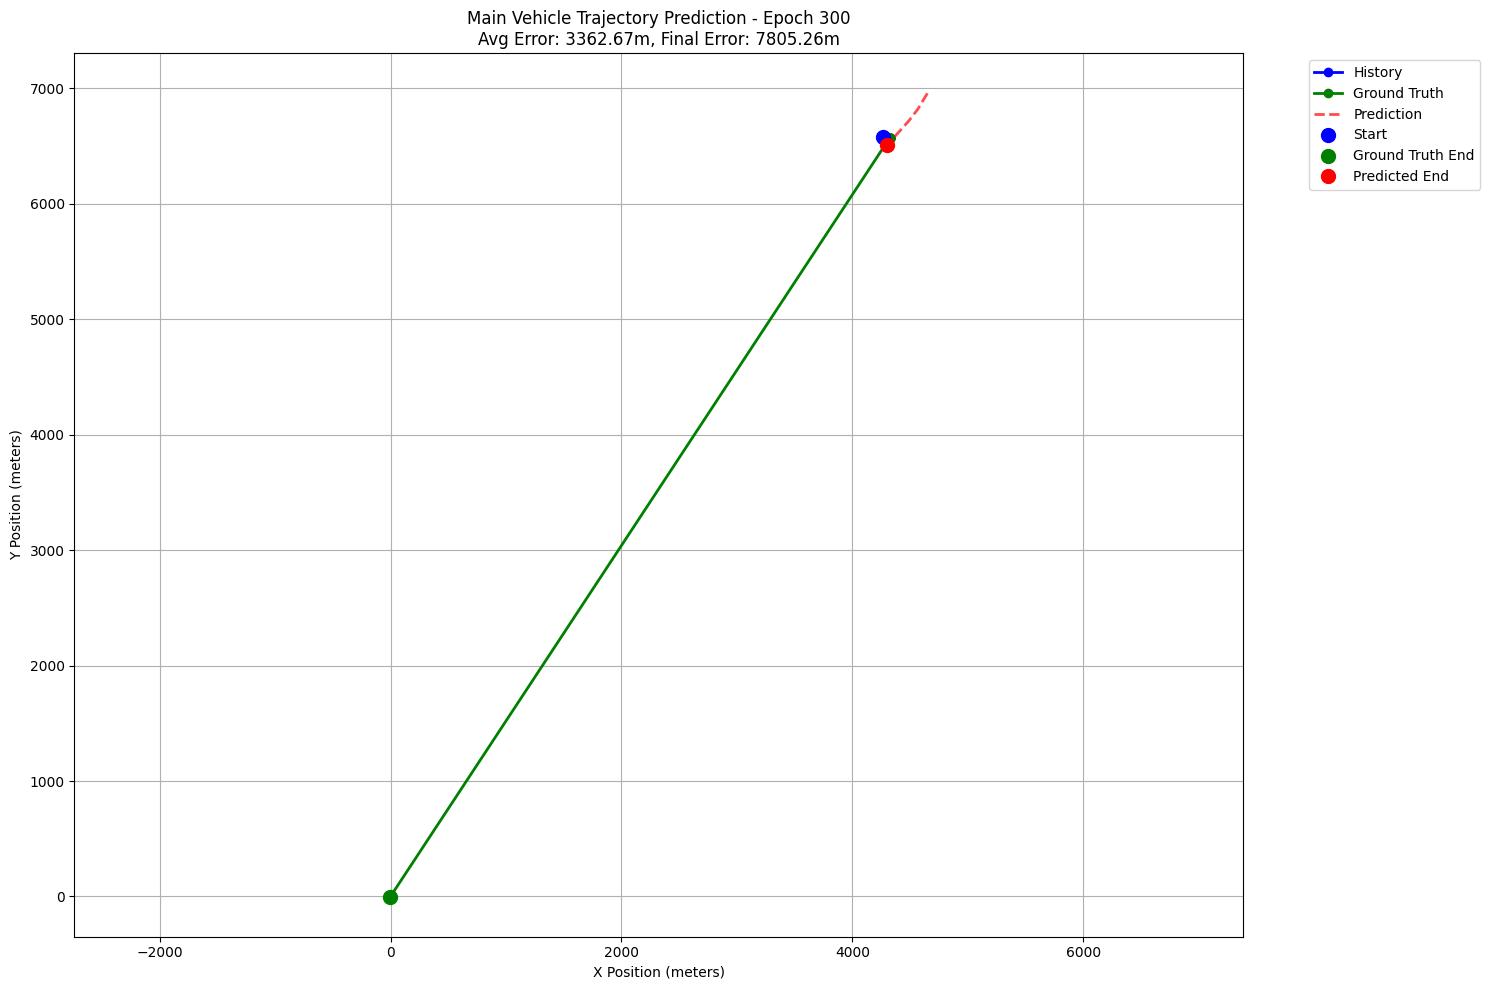


Prediction Statistics:
Average prediction error: 3362.67 meters
Final position error: 7805.26 meters
Trajectory length - History: 11 steps, Future: 80 steps

Epoch 350/500
epoch loss: 0.0001609499886399135
Average loss: 0.000161


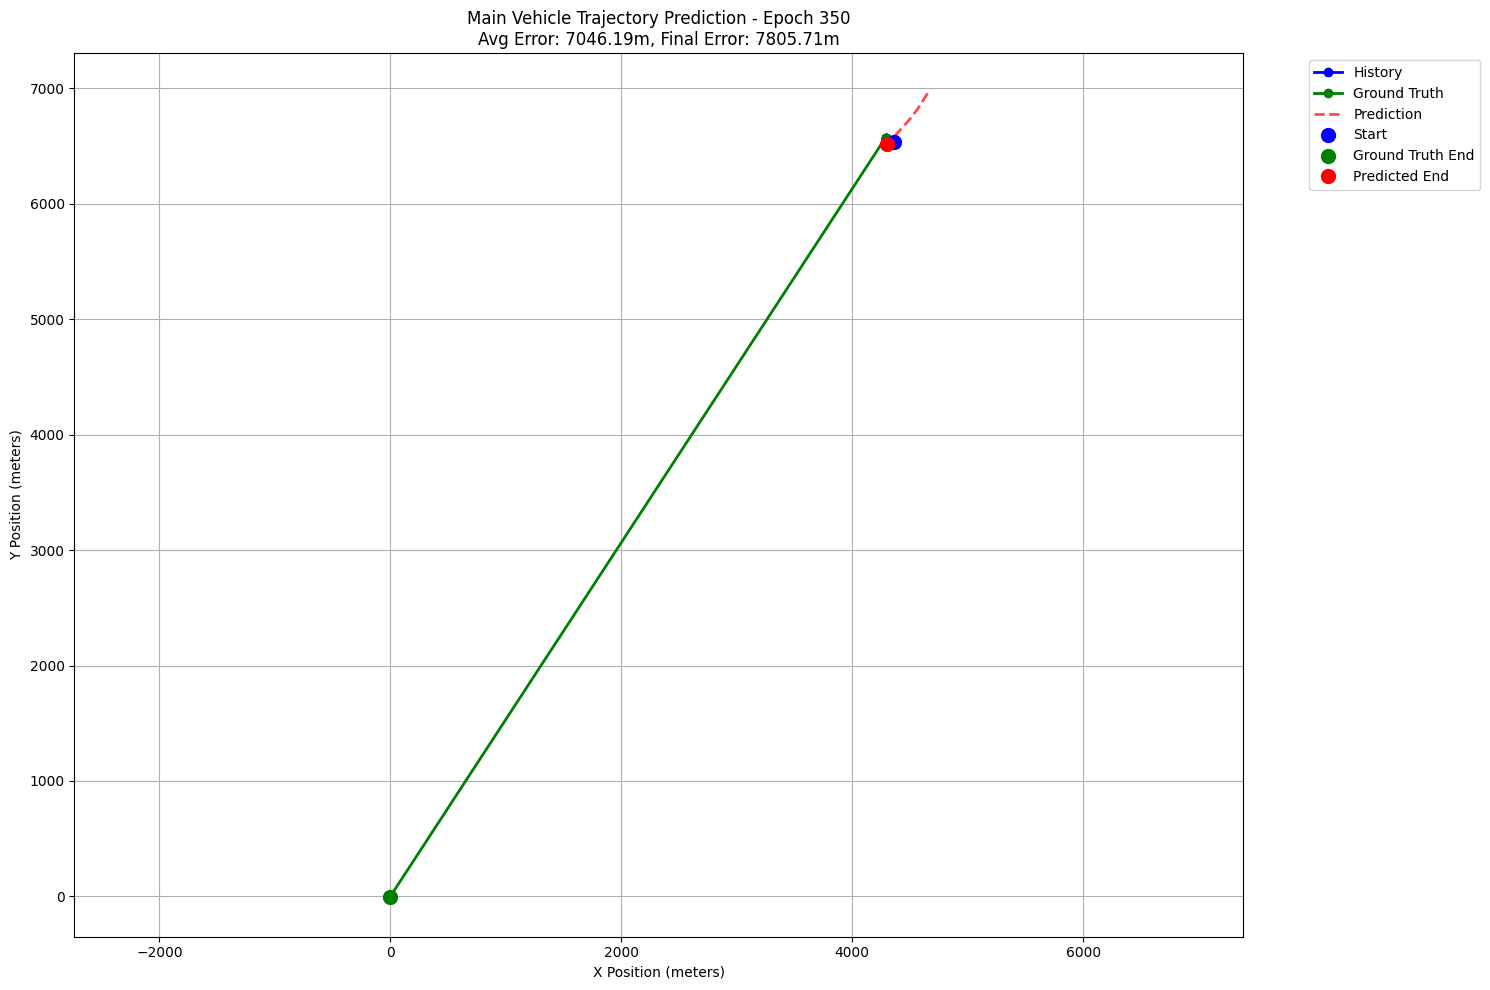


Prediction Statistics:
Average prediction error: 7046.19 meters
Final position error: 7805.71 meters
Trajectory length - History: 11 steps, Future: 80 steps

Epoch 400/500
epoch loss: 0.0001533896429464221
Average loss: 0.000153


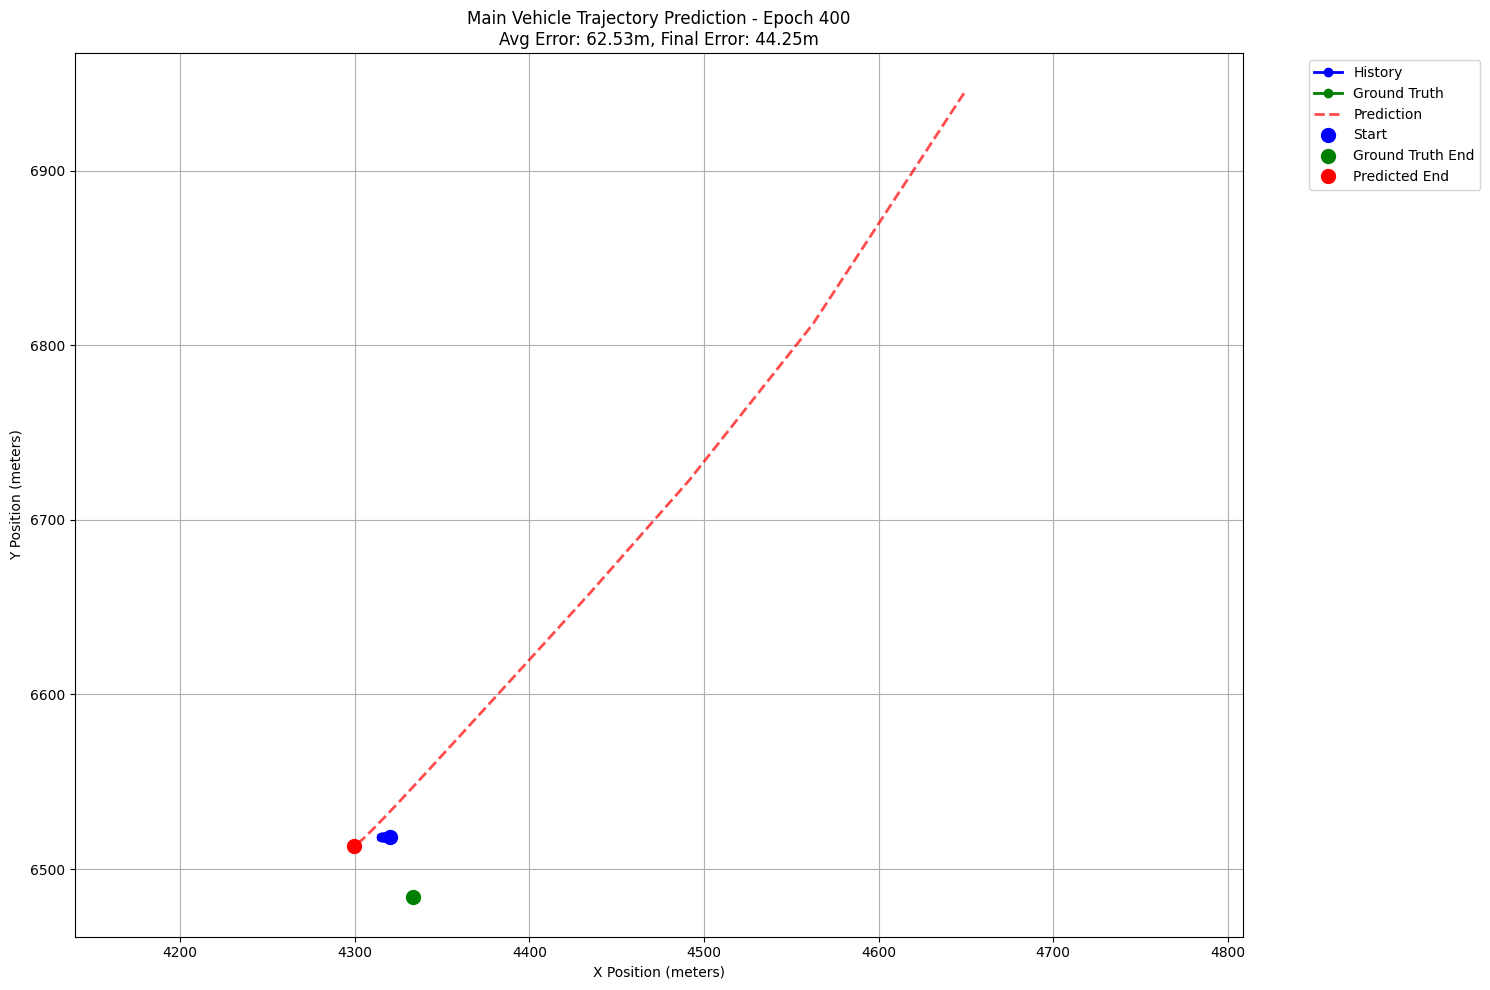


Prediction Statistics:
Average prediction error: 62.53 meters
Final position error: 44.25 meters
Trajectory length - History: 11 steps, Future: 80 steps

Epoch 450/500
epoch loss: 0.00015908679051790386
Average loss: 0.000159


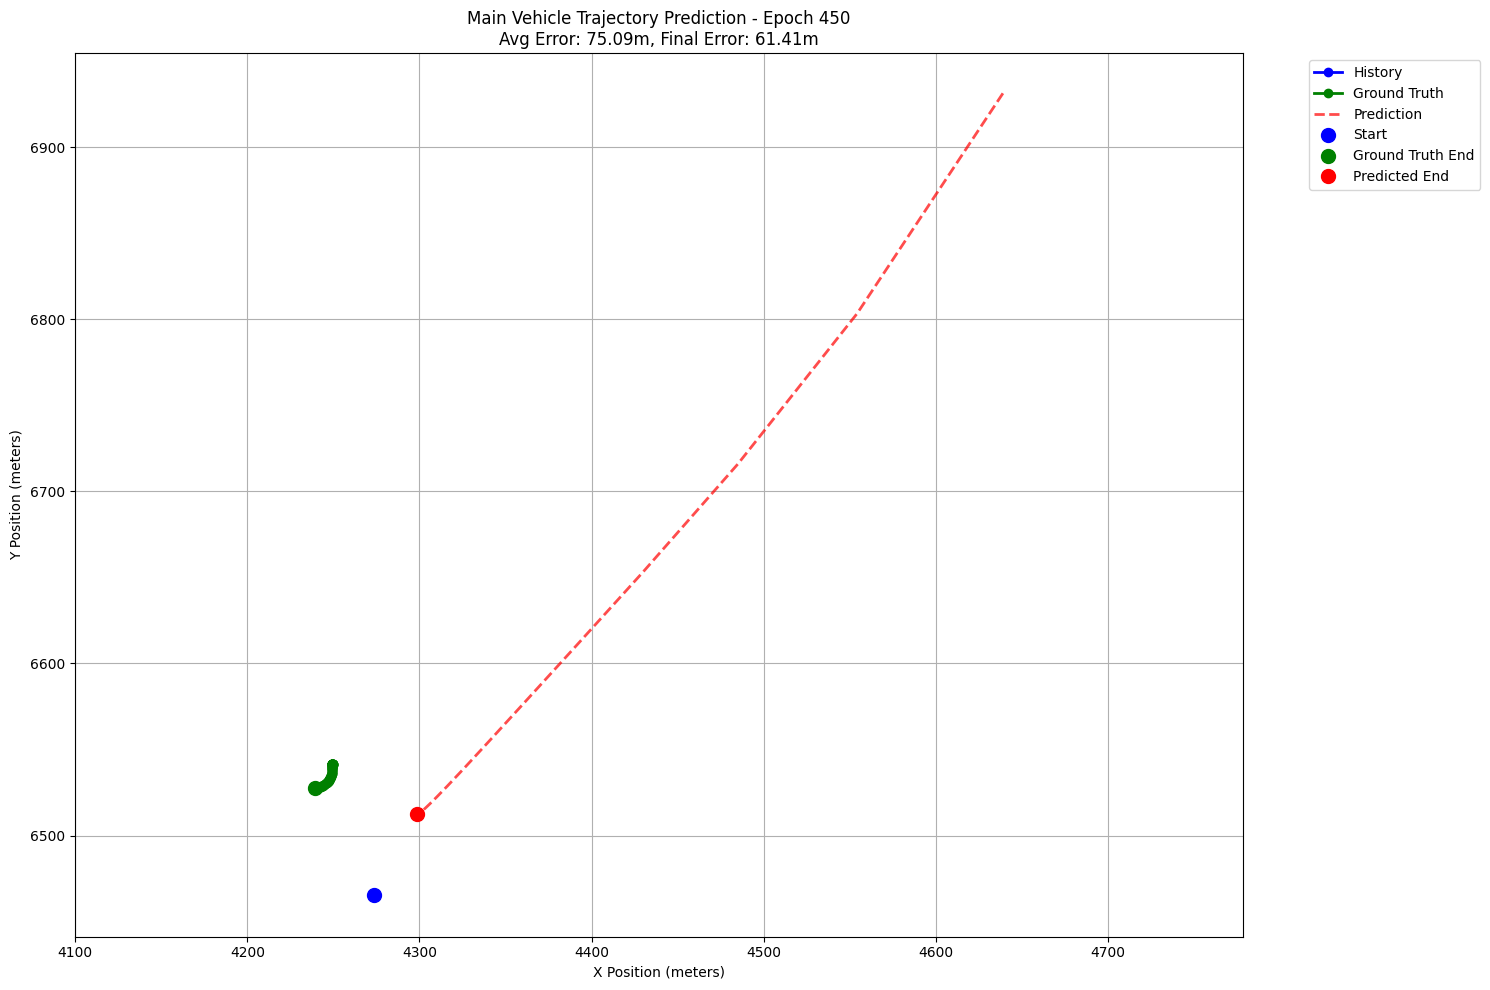


Prediction Statistics:
Average prediction error: 75.09 meters
Final position error: 61.41 meters
Trajectory length - History: 11 steps, Future: 80 steps

Epoch 500/500
epoch loss: 0.00015519518638029695
Average loss: 0.000155


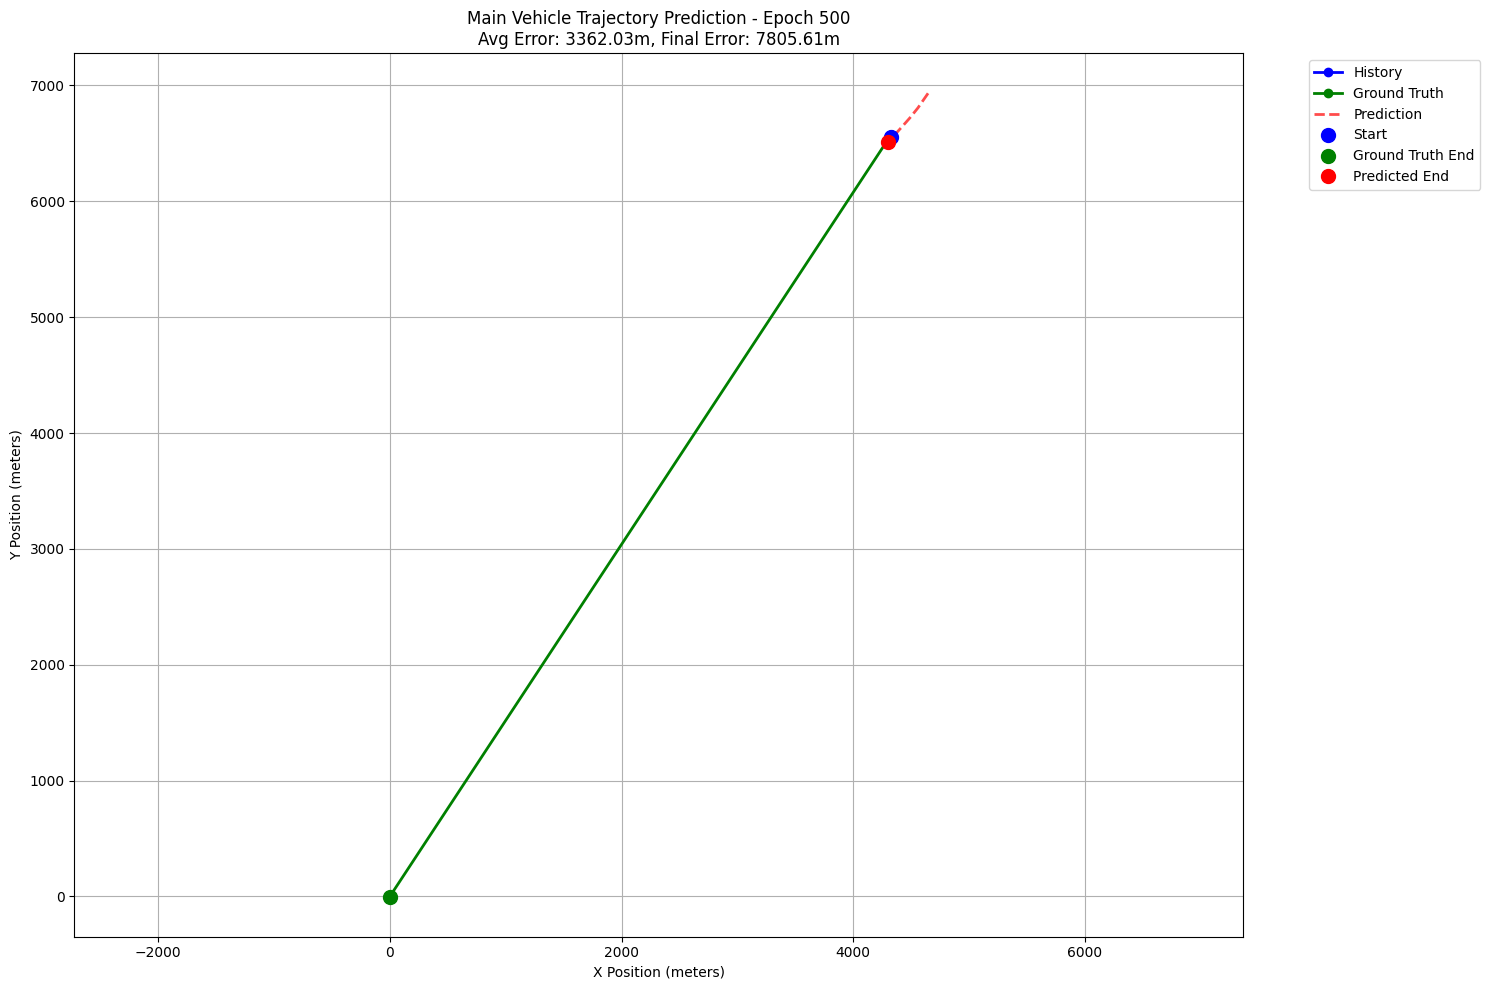


Prediction Statistics:
Average prediction error: 3362.03 meters
Final position error: 7805.61 meters
Trajectory length - History: 11 steps, Future: 80 steps

Training completed!
losses=[0.03584403917193413, 0.03406691178679466, 0.03233018144965172, 0.03066512942314148, 0.029064888134598732, 0.02749646082520485, 0.02601219341158867, 0.024507785215973854, 0.023047402501106262, 0.021617328748106956, 0.020183837041258812, 0.018753301352262497, 0.017335979267954826, 0.015924084931612015, 0.014491701498627663, 0.013048086315393448, 0.011646787635982037, 0.010210942476987839, 0.008747962303459644, 0.007301613222807646, 0.005963937379419804, 0.004619131330400705, 0.0033784930128604174, 0.0022928013931959867, 0.0013778831344097853, 0.0008365177782252431, 0.0007032872526906431, 0.0009887778433039784, 0.0015339860692620277, 0.0020106013398617506, 0.0023824856616556644, 0.002248791977763176, 0.0018884820165112615, 0.0015117014991119504, 0.001148445182479918, 0.0008323945221491158, 0.0006287334836

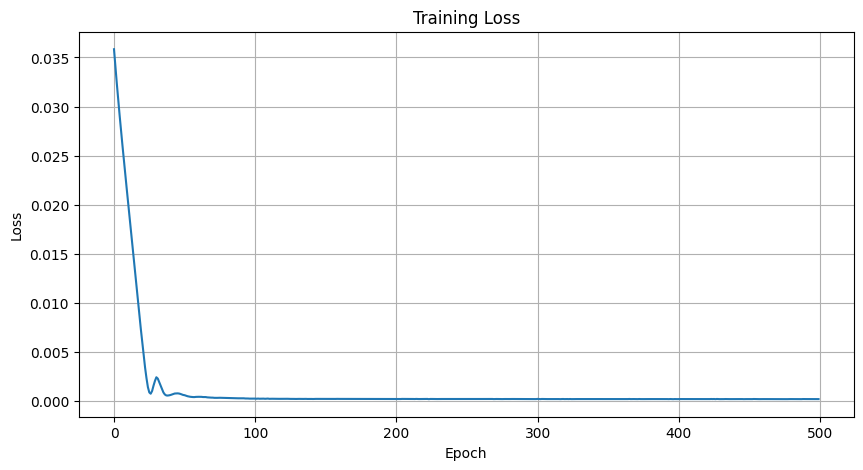

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from trajectory_dataset import TrajectoryDataset
from LSTM_NN_model import TrajectoryPredictorLSTM
from CNN_trajectory_pred import ResidualCNNTrajectoryPredictor
"""
class MainVehiclePredictor:
    def __init__(self, model_path=None):
        self.base_model = TrajectoryPredictorLSTM()
        if model_path:
            self.base_model.load_state_dict(torch.load(model_path))
            
    def train(self, data_path, epochs=200, batch_size=32, lr=0.001):
        # Use your existing dataset but only get the main vehicle
        full_dataset = TrajectoryDataset(data_path)
        
        # Assuming first valid agent is the main vehicle
        main_vehicle_history = full_dataset.history_normalized[0:1]  # Keep batch dimension
        main_vehicle_future = full_dataset.future_normalized[0:1]
        main_vehicle_history_valid = full_dataset.history_valid[0:1]
        main_vehicle_future_valid = full_dataset.future_valid[0:1]
        
        # Training loop
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.base_model = self.base_model.to(device)
        optimizer = torch.optim.Adam(self.base_model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        self.base_model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            # Move data to device
            hist = main_vehicle_history.to(device)
            fut = main_vehicle_future.to(device)
            fut_valid = main_vehicle_future_valid.to(device)
            
            # Forward pass
            pred = self.base_model(hist)
            
            # Calculate loss only on valid points
            loss = criterion(pred * fut_valid.unsqueeze(-1), 
                           fut * fut_valid.unsqueeze(-1))
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
                self.visualize_prediction(hist, fut, pred, epoch, full_dataset)
    
    def predict(self, history):
        self.base_model.eval()
        with torch.no_grad():
            prediction = self.base_model(history)
        return prediction
    
    def visualize_prediction(self, history, future, prediction, epoch, dataset):
        plt.figure(figsize=(10, 10))
        
        # Denormalize
        hist_denorm = dataset.denormalize(history.cpu())
        fut_denorm = dataset.denormalize(future.cpu())
        pred_denorm = dataset.denormalize(prediction.cpu())
        
        # Plot trajectories
        plt.plot(hist_denorm[0, :, 0], hist_denorm[0, :, 1], 
                'b-', linewidth=2, label='History')
        plt.plot(fut_denorm[0, :, 0], fut_denorm[0, :, 1], 
                'g-', linewidth=2, label='Ground Truth')
        plt.plot(pred_denorm[0, :, 0], pred_denorm[0, :, 1], 
                'r--', linewidth=2, label='Prediction')
        
        plt.title(f'Main Vehicle Trajectory Prediction - Epoch {epoch+1}')
        plt.xlabel('X Position (meters)')
        plt.ylabel('Y Position (meters)')
        plt.axis('equal')
        plt.grid(True)
        plt.legend()
        plt.show()



def visualize_prediction(history, future, prediction, epoch, dataset):
 """   """
    Visualize the model's prediction with enhanced styling.
    
    Args:
        history: tensor of shape [1, 11, 2] - normalized historical trajectory
        future: tensor of shape [1, 80, 2] - normalized ground truth future trajectory
        prediction: tensor of shape [1, 80, 2] - normalized predicted future trajectory
        epoch: current training epoch
        dataset: dataset object for denormalization
    """
"""
    # Denormalize all trajectories
    hist_denorm = dataset.denormalize(history.cpu())
    fut_denorm = dataset.denormalize(future.cpu())
    pred_denorm = dataset.denormalize(prediction.cpu())
    
    # Convert to numpy for plotting
    hist_denorm = hist_denorm.numpy()[0]  # [11, 2]
    fut_denorm = fut_denorm.numpy()[0]    # [80, 2]
    pred_denorm = pred_denorm.numpy()[0]   # [80, 2]
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot history trajectory
    plt.plot(hist_denorm[:, 0], hist_denorm[:, 1], 
            'o-', color='blue', alpha=1.0, linewidth=2,
            label='History')
    
    # Plot ground truth future trajectory
    plt.plot(fut_denorm[:, 0], fut_denorm[:, 1], 
            'o-', color='green', alpha=1.0, linewidth=2,
            label='Ground Truth')
    
    # Plot predicted future trajectory
    plt.plot(pred_denorm[:, 0], pred_denorm[:, 1], 
            '--', color='red', alpha=0.7, linewidth=2,
            label='Prediction')
    
    # Add vehicle rectangles at current position (last historical point)
    current_pos = hist_denorm[-1]
    # Assuming a standard vehicle size (you can adjust these)
    width, length = 2.0, 4.0
    
    # Vehicle rectangle at current position
    rect = Rectangle(
        (current_pos[0] - length/2, current_pos[1] - width/2),
        length, width,
        angle=0,  # We don't have yaw information here
        color='blue',
        alpha=0.7,
        linewidth=2
    )
    plt.gca().add_patch(rect)
    
    # Add markers for start and end points
    plt.plot(hist_denorm[0, 0], hist_denorm[0, 1], 'bo', markersize=10, label='Start')
    plt.plot(fut_denorm[-1, 0], fut_denorm[-1, 1], 'go', markersize=10, label='Ground Truth End')
    plt.plot(pred_denorm[-1, 0], pred_denorm[-1, 1], 'ro', markersize=10, label='Predicted End')
    
    plt.title(f'Trajectory Prediction - Epoch {epoch + 1}\n'
             f'Blue: History | Green: Ground Truth | Red: Prediction')
    plt.xlabel('X Position (meters)')
    plt.ylabel('Y Position (meters)')
    plt.axis('equal')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Print prediction statistics
    error = np.mean(np.sqrt(np.sum((fut_denorm - pred_denorm)**2, axis=1)))
    final_error = np.sqrt(np.sum((fut_denorm[-1] - pred_denorm[-1])**2))
    
    print(f"\nPrediction Statistics:")
    print(f"Average prediction error: {error:.2f} meters")
    print(f"Final position error: {final_error:.2f} meters")
    print(f"Trajectory length - History: {len(hist_denorm)} steps, Future: {len(fut_denorm)} steps")
    
    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, epochs=2000, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_idx, ((hist, hist_valid), (fut, fut_valid)) in enumerate(train_loader):
            hist, fut = hist.to(device), fut.to(device)
            hist_valid = hist_valid.to(device)
            fut_valid = fut_valid.to(device)
            
            optimizer.zero_grad()
            pred = model(hist)
            loss = criterion(pred * fut_valid.unsqueeze(-1), fut * fut_valid.unsqueeze(-1))
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Visualize every 10 epochs
        if (epoch + 1) % 50 == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print(f"Average loss: {avg_loss:.6f}")
            
            model.eval()
            with torch.no_grad():
                # Get a sample trajectory
                hist, fut = next(iter(train_loader))[0][0][:1].to(device), next(iter(train_loader))[1][0][:1].to(device)
                pred = model(hist)
                
                # Visualize the prediction
                visualize_prediction(hist, fut, pred, epoch, train_loader.dataset)
    
    print("\nTraining completed!")
    torch.save(model.state_dict(), 'trajectory_model.pth')
    
    # Plot final training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)
    plt.show()
    
    return model, losses



def main():
    # Load and prepare data
    dataset = TrajectoryDataset('processed_data/processed_uncompressed_tf_example_training_training_tfexample.tfrecord-00003-of-01000.npz')
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    # Create and train model
    model = MainVehiclePredictor()
    model, losses = train_model(model, train_loader)
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()"""
    
class MainVehiclePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = TrajectoryPredictorLSTM()
    
    def forward(self, x):
        return self.base_model(x)
lr=0
epochs=0
def train_model(model, train_loader, epochs=epochs, lr=lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_idx, ((hist, hist_valid), (fut, fut_valid)) in enumerate(train_loader):
            # Only take the first vehicle from each batch as main vehicle
            hist = hist[:, 0:1].to(device)  # Take first vehicle
            fut = fut[:, 0:1].to(device)
            hist_valid = hist_valid[:, 0:1].to(device)
            fut_valid = fut_valid[:, 0:1].to(device)
            
            optimizer.zero_grad()
            pred = model(hist)
            loss = criterion(pred * fut_valid.unsqueeze(-1), fut * fut_valid.unsqueeze(-1))
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Visualize every 50 epochs
        if (epoch + 1) % 50 == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print(f"epoch loss: {epoch_loss}")
            print(f"Average loss: {avg_loss:.6f}")
            
            
            model.eval()
            with torch.no_grad():
                # Get a sample trajectory
                hist, fut = next(iter(train_loader))[0][0][:1].to(device), next(iter(train_loader))[1][0][:1].to(device)
                pred = model(hist)
                
                # Visualize the prediction
                visualize_prediction(hist, fut, pred, epoch, train_loader.dataset)
    
    print("\nTraining completed!")
    print(f'losses={losses}')
    torch.save(model.state_dict(), 'trajectory_model.pth')
    
    return model, losses

def visualize_prediction(history, future, prediction, epoch, dataset):
    """
    Visualize the model's prediction with enhanced styling.
    """
    # Denormalize all trajectories
    hist_denorm = dataset.denormalize(history.cpu())
    fut_denorm = dataset.denormalize(future.cpu())
    pred_denorm = dataset.denormalize(prediction.cpu())
    
    # Convert to numpy for plotting
    hist_denorm = hist_denorm.numpy()[0]  # [11, 2]
    fut_denorm = fut_denorm.numpy()[0]    # [80, 2]
    pred_denorm = pred_denorm.numpy()[0]   # [80, 2]
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot history trajectory
    plt.plot(hist_denorm[:, 0], hist_denorm[:, 1], 
            'o-', color='blue', alpha=1.0, linewidth=2,
            label='History')
    
    # Plot ground truth future trajectory
    plt.plot(fut_denorm[:, 0], fut_denorm[:, 1], 
            'o-', color='green', alpha=1.0, linewidth=2,
            label='Ground Truth')
    
    # Plot predicted future trajectory
    plt.plot(pred_denorm[:, 0], pred_denorm[:, 1], 
            '--', color='red', alpha=0.7, linewidth=2,
            label='Prediction')
    
    # Add vehicle rectangle at current position
    current_pos = hist_denorm[-1]
    width, length = 2.0, 4.0
    rect = Rectangle(
        (current_pos[0] - length/2, current_pos[1] - width/2),
        length, width,
        angle=0,
        color='blue',
        alpha=0.7,
        linewidth=2
    )
    plt.gca().add_patch(rect)
    
    # Add markers for start and end points
    plt.plot(hist_denorm[0, 0], hist_denorm[0, 1], 'bo', markersize=10, label='Start')
    plt.plot(fut_denorm[-1, 0], fut_denorm[-1, 1], 'go', markersize=10, label='Ground Truth End')
    plt.plot(pred_denorm[-1, 0], pred_denorm[-1, 1], 'ro', markersize=10, label='Predicted End')
    
    # Calculate and display errors
    error = np.mean(np.sqrt(np.sum((fut_denorm - pred_denorm)**2, axis=1)))
    final_error = np.sqrt(np.sum((fut_denorm[-1] - pred_denorm[-1])**2))
    
    plt.title(f'Main Vehicle Trajectory Prediction - Epoch {epoch + 1}\n'
             f'Avg Error: {error:.2f}m, Final Error: {final_error:.2f}m')
    plt.xlabel('X Position (meters)')
    plt.ylabel('Y Position (meters)')
    plt.axis('equal')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    print(f"\nPrediction Statistics:")
    print(f"Average prediction error: {error:.2f} meters")
    print(f"Final position error: {final_error:.2f} meters")
    print(f"Trajectory length - History: {len(hist_denorm)} steps, Future: {len(fut_denorm)} steps")

def main():
    # Load and prepare data
    dataset = TrajectoryDataset('processed_data/processed_uncompressed_tf_example_training_training_tfexample.tfrecord-00005-of-01000.npz')
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    # Create and train model
    model = MainVehiclePredictor()
    model, losses = train_model(model, train_loader, epochs=500, lr=0.0009)
        # Create and train model
    
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
def test_model(model_path, test_data_path):
   # Load the model
   model = TrajectoryPredictor()
   model.load_state_dict(torch.load(model_path))
   model.eval()
   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   model = model.to(device)
   
   # Load test data
   test_dataset = TrajectoryDataset(test_data_path)
   test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
   
   # Testing metrics
   total_error = 0
   predictions = []
   ground_truths = []
   
   with torch.no_grad():
       for i, ((hist, hist_valid), (fut, fut_valid)) in enumerate(test_loader):
           hist, fut = hist.to(device), fut.to(device)
           
           # Get prediction
           pred = model(hist)
           
           # Denormalize
           hist_denorm = test_dataset.denormalize(hist.cpu())
           fut_denorm = test_dataset.denormalize(fut.cpu())
           pred_denorm = test_dataset.denormalize(pred.cpu())
           
           # Visualize some examples
           if i % 10 == 0:  # Show every 10th prediction
               plt.figure(figsize=(10, 10))
               plt.plot(hist_denorm[0, :, 0], hist_denorm[0, :, 1], 'b-', label='History')
               plt.plot(fut_denorm[0, :, 0], fut_denorm[0, :, 1], 'g-', label='Ground Truth')
               plt.plot(pred_denorm[0, :, 0], pred_denorm[0, :, 1], 'r--', label='Prediction')
               plt.legend()
               plt.title(f'Test Sample {i}')
               plt.grid(True)
               plt.axis('equal')
               plt.show()
           
           # Calculate error
           error = ((pred_denorm - fut_denorm) ** 2).mean()
           total_error += error.item()
           
           predictions.append(pred_denorm)
           ground_truths.append(fut_denorm)
   
   avg_error = total_error / len(test_loader)
   print(f"Average test error: {avg_error:.6f}")
   
   return predictions, ground_truths, avg_error

# Example usage (update paths accordingly):
predictions, ground_truths, avg_error = test_model('trajectory_model.pth', 'processed_data_testing/processed_uncompressed_tf_example_testing_testing_tfexample.tfrecord-00001-of-00150.npz')